# 概要

解説記事「[量子アニーリングとADMMのハイブリッド方式による不等式制約への対処](https://qard.is.tohoku.ac.jp/T-Wave/?p=5782)」では、不等式制約付きの組合せ最適化問題を解くために、量子アニーリング（QA : Quantum Annealing）と ADMM（Alternating Direction Method of Multipliers）を組み合わせた手法を提案した論文を紹介しました。本記事では、そのアルゴリズムを実装し、元論文の再現実験を行います。

# 文献情報

* タイトル : Solving Inequality-Constrained Binary Optimization Problems on Quantum Annealer
* 著者 : Kouki Yonaga, Masamichi J. Miyama, Masayuki Ohzeki
* 書誌情報 :
https://doi.org/10.48550/arXiv.2012.06119

# 手法

はじめに、元論文において提案された手法を簡単に振り返ります（詳細は[解説記事](https://qard.is.tohoku.ac.jp/T-Wave/?p=5782)に記載しています）。

## 拡張ラグランジュ法

元論文（および本記事）では、以下のような不等式制約付きの最小化問題を解くことを目的としています。

$$\min_{\pmb x} \quad f ({\pmb x}), \quad {\rm subject \ to} \quad {\pmb G}_{m} {\pmb x} \le {D}_{m} \quad (\ m=1,\cdots, M\ )\tag{1}$$

ここで、$\pmb x$ は二値変数の $N$ 次元ベクトル、${\pmb G}_{m}$ は整数の $N$ 次元ベクトル、$D_{m}$ は整数です。そして、$f({\pmb x})$ は QUBO 形式で定義される目的関数です。

式 (1) の不等式制約は、以下のコスト関数として記述することができます（ここで言うコスト関数とは、対象の組合せ最適化問題を解くために最小化する関数のことです）。

$$E_{\rm ineq} = f({\pmb x}) + \gamma \sum_{m=1}^{M} \Theta \left( {\pmb G}_{m} {\pmb x} - D_{m} \right) \tag{2}$$

ここで、$\Theta$ $(x)$ はヘヴィサイドのステップ関数で、$x>0$ のときに $1$ を取り、$x \le 0$ のときに $0$ を取ります。したがって、任意の $m$ について$\Theta ( {\pmb G}_{m} {\pmb x}^{\ast} - D_{m} ) = 0 $ が成り立つとき ${\pmb x}^{\ast}$ は実行可能解となります。

しかし、式 (2) の $E_{\rm{ineq}}$ はステップ関数を含んでいるため、そのまま QUBO 形式にすることはできません（したがって、D-Wave マシンで最小化することができません）。そこで、補助的な変数 $z_m$ を導入し、 $E_{\rm{ineq}}$ の最小化問題を一旦以下のように書き換えます。

$$\min_{\pmb x} \quad f({\pmb x}) + \gamma \sum_{m=1}^{M} \Theta (z_m), \quad {\rm subject \ to} \quad {\pmb G}_{m} {\pmb x} - D_{m} = z_{m} \ (\ m=1,\cdots, M\ ) \tag{3} $$

ここで、$z_m$ は整数の $M$ 次元ベクトルです。そして、
式 (3) に対して拡張ラグランジュ法を適用し、新たなコスト関数 $E_{\rm{au}g}$ を定義します。

$$E_{\rm aug} ({\pmb x}, {\pmb z}, {\pmb \lambda}) = f({\pmb x}) + \gamma \sum_{m=1}^{M} \Theta (z_{m}) + \sum_{m=1}^{M} \lambda_{m} \left( {\pmb G}_{m} {\pmb x} - D_m -z_m \right) +\frac{\rho}{2} \sum_{m=1}^{M} \left( {\pmb G}_{m} {\pmb x}-D_m - z_m \right)^2 \quad \tag{4}$$

ここで、$\lambda_m, \rho$ はラグランジュ未定定数です。以下で説明する ADMM アルゴリズムは、式 (4) の $E_{\rm{aug}}$ の最小化を目指しています。

## メインアルゴリズム

それでは、式 (4) を最小化する ADMM アルゴリズムを以下に示します。



1.   パラメータの初期化：$\{ z_m \}=0, \ \{ \lambda_m \} = 0, \ t=1$

2.   問題サイズ $N$ の全結合グラフを embedding する

3.   後述する式 (8) を用いて QUBO 行列を計算する

4.   QUBO 行列をアニーリングしてサンプル $\{ {\pmb x}_{\nu} \}$ を取得する

5.   サンプル $\{ {\pmb x}_{\nu} \}$ から ${\pmb x}_{\rm cost}^{\ast}$ と ${\pmb x}_{\rm feas}^{\ast}$ を計算する

6.   $z_m^{\ast}={\rm min}(0, {\pmb G}_{m} {\pmb x}_{\rm cost}^{\ast}-D_{m}) \ (\ m=1,\cdots, M\ )$ により $z_m^{\ast}$ を更新する

7.   $\lambda_{m} = \lambda_{m} + \rho\ ({\pmb G}_{m}{\pmb x}_{\rm cost}^{\ast}-D_{m}-z_{m}^{\ast})\ (\ m=1,\cdots, M\ )$ により $\lambda$ を更新する

8.   収束の確認：以下の条件のうち一つでも満たされたら計算を終了する（条件内のパラメータ $t_{\rm max}\ , \ t_{\rm conv}\ , \ \epsilon$ は事前に設定する）

  *   $t>t_{\rm{max}}$（ 最大ステップ数 ）
  *   $E_{\rm ineq} \ ({\pmb x}_{\rm feas}^{\ast}\ )$ が $t_{\rm conv}$ ステップの間改善されない
  *   $\sqrt{\sum_{m} ({\pmb G}_{m} {\pmb x}_{\rm feas}^{\ast} - D_m - z_m)^2 } < \epsilon$

9.   $t \leftarrow t+1$

10.    手順 (3)~(10) を収束するまで繰り返す

ここで、${\pmb x}_{\rm{cost}}^{\ast}$ は以下のように定義します。

$${\pmb x}_{\rm cost}^{\ast}={\rm argmin}_{\{\pmb x_{\nu}\}} \quad E_{\rm aug} \ ({\pmb x}, {\pmb z}, {\pmb \lambda})\tag{5}$$

すなわち、サンプル $\{ {\pmb x}_{\nu} \}$ の中で、$E_{\rm aug}$ $({\pmb x}, {\pmb z}, {\pmb \lambda})$ を最小にするものを指します。

そして、${\pmb x}_{\rm feas}^{\ast}$ は以下のように定義します。

$${\pmb x}_{\rm feas}^{\ast}={\rm argmin}_{\{ {\pmb x}_{\nu} \}} \quad f({\pmb x}) \quad {\rm subject \ to} \quad {\pmb G}_{m} {\pmb x} \le {\pmb D}_{m} \quad (m=1,\cdots, M) \tag{6}$$

すなわち、サンプル $\{ {\pmb x}_{\nu} \}$ の中で、全ての不等式制約を満たすもののうち、$f({\pmb x})$ を最小にする解を指します。したがって、アルゴリズムの実行後に出力する解です。

# 実験

## 準備：各種ライブラリのインストール

まずは、実装に必要な各種ライブラリをインストールします。

In [ ]:
!pip -q -q -q install numpy
!pip -q -q -q install matplotlib
!pip -q -q -q install openjij
!pip -q -q -q install gurobipy
!pip -q -q -q install dwave-system

In [ ]:
import copy
import math
import random
from statistics import mean, stdev, variance, median
from tqdm import trange

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import openjij as oj
import gurobipy as gp
from gurobipy import GRB
from dwave.system import DWaveCliqueSampler

## ADMM アルゴリズムの実装

### 各種の補助的な関数の定義

次に、ADMM アルゴリズムの中で補助的に用いる関数を定義していきます。

はじめに、式 (4) の $E_{\rm{aug}}$ から QUBO 行列を計算する関数 compute_qubo_matrix を定義します。式 (4)を 展開して変数 $\pmb{x}$ が含まれる項を残すと以下のようになります。

$$E_{\rm aug}({\pmb x}, {\pmb z}, {\pmb \lambda})=f({\pmb x})+\sum_{m=1}^{M} \lambda_{m}\sum_{i=1}^{N}G_{m, i} x_i + \frac{\rho}{2}\sum_{m=1}^{M} \left( \sum_{i=1}^{N} G_{m, i} x_{i} \right)^2 - \rho \sum_{m=1}^{M} \left( D_{m}+z_{m} \right) \sum_{i=1}^{N} G_{m, i} x_{i} \tag{7}$$

※ QA では変数 ${\pmb x}$ について最適化するため、変数 ${\pmb z}$ の項は無視することができます。

さらに第 3 項について展開し、${\pmb x}$ について以下のように整理することができます。

$$E_{\rm aug} ({\pmb x}, {\pmb z}, {\pmb \lambda}) = f({\pmb x}) + \sum_{m=1}^{M} \sum_{i=1}^{N} \left\{ \lambda_{m} - \rho \left( D_{m}+z_{m} - \frac{1}{2} G_{m,i} \right) \right\} G_{m,i} x_{i} + \rho \sum_{m=1}^{M} \sum_{i<j} G_{m,i} G_{m,j} x_i x_j$$

In [ ]:
def compute_qubo_matrix(f, z, lam, G, D, rho, M, N):
    Q = np.array([[f[i, j] for j in range(N)] for i in range(N)])  # まず f(x) の代入
    # その他の項の代入
    for m in range(M):
        for i in range(N):
            Q[i, i] += (lam[m] - rho * (D[m] + z[m] - 0.5 * G[m, i])) * G[
                m, i
            ]  # 対角項
            for j in range(i + 1, N):
                Q[i, j] += rho * G[m, i] * G[m, j]  # 非対角項
    return Q

次に、上の compute_qubo_matrix 関数から得られた QUBO 行列を QA によって最適化する関数 annealing_qubo_matrix を定義します。

In [ ]:
def annealing_qubo_matrix(Q, N_nu, sampler):
    # N_nu はサンプル数
    sampleset = sampler.sample_qubo(Q, num_reads=N_nu)
    return sampleset.record.sample

続いて、サンプル ${\pmb x}_{\nu}$ が与えられたときに、式 (7) に基づいて $E_{\rm aug}$ を計算する関数 compute_E_aug を定義します。この関数は ${\pmb x}_{\rm cost}^{\ast}$ を求める際に使用します。

In [ ]:
def compute_E_aug(x, f, z, lam, G, D, rho, M):
    E_aug = np.dot(np.dot(x, f), x)  # f(x) の計算
    for m in range(M):
        Gx = np.dot(G[m, :], x)
        E_aug += lam[m] * Gx + rho * 0.5 * (Gx**2) - rho * (D[m] + z[m]) * Gx
    return E_aug

式 (5) に基づいて ${\pmb x}_{\rm cost}^{\ast}$ を求める関数 compute_x_cost を定義します。この関数内で、上で定義した compute_E_aug 関数を使用します。

In [ ]:
def compute_x_cost(x_nu, f, z, lam, G, D, rho, M):
    # まず最初のインデックスのサンプルを入れておく
    E_temp = compute_E_aug(x_nu[0], f, z, lam, G, D, rho, M)
    x_cost = x_nu[0]
    # 二番目以降のサンプルについて E_aug を最小にするもの (x_cost*) を探索
    for nu in range(1, len(x_nu)):
        E_aug = compute_E_aug(x_nu[nu], f, z, lam, G, D, rho, M)
        if E_aug <= E_temp:
            E_temp = E_aug
            x_cost = x_nu[nu]
    return x_cost

式 (6) に基づいて $\pmb{x}_{\rm{feas}}^{\ast}$ を求める関数 compute_x_feas を定義します。

In [ ]:
def compute_x_feas(x_nu, f, G, D, M):
    f_list = []
    x_feas_list = []
    for x in x_nu:  # すべてのサンプルについて
        # すべての m について不等式条件を満たしているか確認
        if not all(np.dot(G[m, :], x) <= D[m] for m in range(M)):
            continue

        f_temp = np.dot(x, np.dot(f, x))  # f(x) の計算
        f_list.append(f_temp)
        x_feas_list.append(x)

    if len(x_feas_list) == 0:  # 不等式条件を満たすリストが無かった場合
        return []
    else:
        return x_feas_list[
            f_list.index(min(f_list))
        ]  # x_feas_list の中で、f(x) を最小にするもの (x_feas*) を返す

サンプル ${\pmb x}_{\nu}$ が与えられたときに、式 (2) に基づいて $E_{\rm ineq}$ を計算する関数 compute_E_ineq を定義します。

In [ ]:
def compute_E_ineq(f, gamma, G, x, D, M):
    E_ineq = np.dot(x, np.dot(f, x))  # f(x) の計算

    for m in range(M):
        f_step = int(np.dot(G[m, :], x) > D[m])  # ステップ関数 Theta(G*x - D)
        E_ineq += gamma * f_step
    return E_ineq

アルゴリズムの手順 8. で 3 つの収束条件をチェックする関数 check_convergence を定義します。また、check_convergence 関数内で使用する compute_criteria3 (収束条件 3 をチェックする関数) も併せて定義します。

In [ ]:
def compute_criteria3(x_feas, G, D, z, M, epsilon):
    sum_c3 = np.sum([(np.dot(G[m, :], x_feas) - D[m] - z[m]) ** 2 for m in range(M)])
    return (
        math.sqrt(sum_c3) < epsilon
    )  # 収束条件 3 を満たす場合には True、そうでなければ False を返す

In [ ]:
def check_convergence(t, t_max, E_ineq, x_feas, G, D, z, t_conv, epsilon, M, log=True):
    if t > t_max:  # 収束条件 1 を満たす場合
        if log:
            print("condition : criteria 1 is satisfied.")
        return True
    if (
        len(E_ineq) >= t_conv and len(set(E_ineq[-t_conv:])) <= 1
    ):  # 収束条件 2 を満たす場合
        if log:
            print("condition : criteria 2 is satisfied.")
        return True
    if len(x_feas) != 0 and compute_criteria3(
        x_feas, G, D, z, M, epsilon
    ):  # 収束条件 3 を満たす場合
        if log:
            print("conditon : criteria 3 is satisfied.")
        return True
    return False

### ADMM アルゴリズム本体の定義

これまで作成してきた関数を用いて ADMM アルゴリズムの本体を定義していきます。アルゴリズムの手順 2. に対応する embedding では DWaveCliqueSampler() を用いることで全結合グラフを埋め込むことができます。これにより、全結合グラフ （clique） 用に予め用意された埋め込みが適用されることになります。また、今回は QA として D-Wave Advantage system6.3 を使用します。

In [ ]:
def qa_admm(f, G, D, rho, M, N_nu, N, t_max, t_conv, epsilon, gamma):
    E_ineq = []

    # 手順 1 : パラメータの初期化
    z = np.zeros(M)
    lam = np.zeros(M)
    t = 1

    # 手順 2 : 全結合グラフ (サイズ N) の embedding を行う ( = sampler の指定)
    dw_sampler = DWaveCliqueSampler(token="YOUR TOKEN", solver="Advantage_system6.3")

    # SA の場合 (埋め込みは無し)
    # sa_sampler = oj.SASampler()

    while True:  # 収束条件を満たすまで繰り返す
        # print("-" * 50)
        # print("number of iterations = ", t)

        # 手順 3 : QUBO 行列を計算する
        Q = compute_qubo_matrix(f, z, lam, G, D, rho, M, N)
        """
        plt.imshow(Q)
        plt.colorbar()
        """
        # 手順 4 : QUBO 行列をアニーリングしてサンプルを取得
        x_nu = annealing_qubo_matrix(Q, N_nu, dw_sampler)

        # 手順 5 : x_cost* と x_feas* を計算する
        x_cost = compute_x_cost(x_nu, f, z, lam, G, D, rho, M)
        # print("x_cost = ", x_cost)
        x_feas = compute_x_feas(x_nu, f, G, D, M)
        # print("x_feas = ", x_feas)

        for m in range(M):
            Gx_cost = np.dot(G[m, :], x_cost)

            # 手順 6 : z をアップデートする
            z[m] = min(0, Gx_cost - D[m])
            # print("z[0] = ", z[m])

            # 手順 7 : lambda をアップデートする
            lam[m] += rho * (Gx_cost - D[m] - z[m])
            # print("dot_Gmx_cost = ", Gx_cost)
            # print("dot_Gmx_cost-D[m]-z[m] = ", Gx_cost-D[m]-z[m])
            # print("lambda[0] = ", lam[m])

        # 手順 8 : 収束しているかどうかをチェックする
        if len(x_feas) != 0:
            E_ineq.append(compute_E_ineq(f, gamma, G, x_feas, D, M))
        # print("E_ineq = ", E_ineq)
        if check_convergence(
            t, t_max, E_ineq, x_feas, G, D, z, t_conv, epsilon, M, log=False
        ):
            break

        # 手順 9 : 反復回数 t を更新する
        t += 1

    return x_feas, E_ineq

## 解きたい最適化問題（QKP）の定義

実装した ADMM アルゴリズムの精度を評価するために、元論文と同様に二次ナップサック問題（QKP : Quadratic Knapsack Problem）を解いていきます。QKP は以下のように定義されます。

$$\max_{\pmb x} \quad {\pmb x}^{\top}P {\pmb x},\quad {\rm subject \quad to} \quad {\pmb w}^{\top} {\pmb x} \le c \tag{8}$$

式 (8) において、$x_i \ (i=1,\cdots, N)$ は $i$ 番目のアイテムをナップサックに入れる時に $1$、入れない時に $0$ を取ります。$P= \{ p_{i, j} \}$ は自然数からなる $N\times N$ の行列で、$i$ 番目と $j$ 番目のアイテムをナップサックに入れたときの価値を表します。$\pmb{w}$ は正の整数の $N$ 次元ベクトルで、各アイテムの重量を表します。そして、$c$ は容量（重量制限）を表す正の整数です。

実験では、$P$、${\pmb w}$、${\pmb x}$ をランダムに生成します。具体的には、価値 $\{ p_{i, j}\}$ は確率 $(1-\Delta)$ でゼロ、確率 $\Delta$ で非ゼロとします。非ゼロの値は、$1$ から $100$ の一様分布から選びます。重量 $w_i$ についても $1$ から $50$ の一様分布からランダムに選びます。そして、容量 $c$ は $50$ から $\sum_{i}w_i$ の一様分布からランダムに選びます。

アルゴリズムの典型的な性能を評価するために、このランダムな QKP を 10 個生成します（すなわちインスタンスの数 $N_{\rm{inst}}=10$ ）。

なお、${\pmb w}$ および $c$ はそれぞれ式 (1) の ${\pmb G}_{m}$ および $D_m$ に対応し、$\max_{\pmb x} \ {\pmb x}^{\top} P {\pmb x}$ は $\max_{\pmb x} \ f({\pmb x})= - {\pmb x}^{\top}P {\pmb x}$ に対応します。

以下に、ランダムな QKP を生成する関数 make_QKP を定義します。

In [ ]:
def make_QKP(N, M, Delta):
    f = np.zeros((N, N))
    G = np.zeros((M, N))
    D = np.zeros((M))

    for i in range(N):
        for j in range(i, N):
            if random.uniform(0, 1) <= Delta:
                f[j, i] = -random.randint(1, 100)  # 最大化問題なので、符号を反転させる

    for i in range(N):
        G[0, i] = random.randint(1, 50)
    D[0] = random.randint(50, np.sum(G[0, :]))

    return f, G, D

## ADMM アルゴリズムの性能評価

$\Delta = 0.2, 0.6, 1.0$ の場合それぞれについて、問題サイズ $ N=8,16,32,64 $ の QKP を 10 個ずつ生成し、ADMM アルゴリズムで解を求めていきます。そして、各 QKP に対する厳密解を Gurobi で求め、ADMM アルゴリズムの解と比較します。まずは、アルゴリズムの各種パラメータを設定しておきます。

In [ ]:
rho = 0.1
t_max = 30
t_conv = 10
epsilon = 10 ** (-3)
gamma = 100
N_nu = 2000  # サンプル数

In [ ]:
N_inst = 10  # インスタンスの数
N_list = [8, 16, 32, 64]
len_N_list = len(N_list)
M = 1  # 不等式制約の数（式(8)より１個）

### $\Delta=0.2$ の場合

問題サイズ $ N=8,16,32,64 $ の QKP をランダムに 10 個ずつ生成していきます。

In [ ]:
Delta02 = 0.2

f_inst_D02 = []
G_inst_D02 = []
D_inst_D02 = []

for N in N_list:
    for i in range(N_inst):
        f, G, D = make_QKP(N, M, Delta02)
        f_inst_D02.append(f)
        G_inst_D02.append(G)
        D_inst_D02.append(D)

#### ADMM アルゴリズムの実行

生成した QKP（計 40 個）に対して ADMM アルゴリズムを実行し、解を求めていきます。

In [ ]:
x_feas_inst_D02 = []
E_ineq_inst_D02 = []

for i in trange(N_inst * len_N_list):
    x_feas, E_ineq = qa_admm(
        f_inst_D02[i],
        G_inst_D02[i],
        D_inst_D02[i],
        rho,
        M,
        N_nu,
        N_list[i // N_inst],
        t_max,
        t_conv,
        epsilon,
        gamma,
    )
    x_feas_inst_D02.append(x_feas)
    E_ineq_inst_D02.append(E_ineq)

100%|██████████| 40/40 [10:48<00:00, 16.21s/it]


#### Gurobi から厳密解を取得

今度はそれぞれの QKP に対して Gurobi を実行し、厳密解を求めていきます。まずは Gurobi で厳密解を求める関数 grb_exact_qkp を定義します。

In [ ]:
def grb_exact_qkp(P, w, c):
    N = len(w)
    # 問題を設定
    QKP = gp.Model(name="QKP")

    # 変数を設定（変数単体にかかる制約を含む）
    x = {}
    for i in range(N):
        x[i] = QKP.addVar(vtype="B", name="x[%x]" % i)

    # 目的関数を設定
    QKP.setObjective(
        sum(sum(x[i] * P[i, j] * x[j] for i in range(N)) for j in range(N)),
        GRB.MINIMIZE,
    )
    # 制約を設定
    QKP.addConstr(sum(w[i] * x[i] for i in range(N)) <= c, name="constraint")

    # ログを切る
    QKP.params.LogToConsole = 0
    # 解を求める
    QKP.optimize()
    if QKP.Status != GRB.OPTIMAL:
        raise Exception("最適解が得られませんでした")
    return np.array([x[i].x for i in range(N)]), QKP.ObjVal  # 厳密解とそのコストを返す

この関数を用いて、各 QKP の厳密解を求めます。

In [ ]:
x_opt_inst_D02 = []
E_opt_inst_D02 = []

for k in trange(N_inst * len_N_list):
    x_exact, val_opt = grb_exact_qkp(f_inst_D02[k], G_inst_D02[k][0], D_inst_D02[k][0])
    x_opt_inst_D02.append(x_exact)
    E_opt_inst_D02.append(val_opt)

100%|██████████| 40/40 [00:01<00:00, 25.96it/s] 


#### 結果の比較

ADMM アルゴリズムで得られた解と Gurobi の厳密解とを比較します。厳密解と比較した ADMM アルゴリズムの精度をここでは MAPE で評価します。MAPE は以下のように定義されます。

$${\rm MAPE}=\frac{1}{N_{\rm inst}}\sum_{k=1}^{N_{\rm inst}} \frac{| f_{k}({\pmb x}_{\rm opt}^{\ast} \ ) - f_{k}({\pmb x}_{\rm feas}^{\ast})  |}{f_{k}({\pmb x}_{\rm opt}^{\ast}\ ) }\tag{9}$$

ここで、$N_{\rm inst}$ はインスタンスの数（したがって $10$）、$f_k({\pmb x}_{\rm opt}^{\ast})$ は $k$ 番目のインスタンスについて Gurobi から得た最適解（に対応する目的関数）、$f_k({\pmb x}_{\rm feas}^{\ast})$ は ADMM アルゴリズムから得た最適解（〃）です。

式(9)に基づき、問題サイズごとに MAPE のインスタンス平均および標準誤差を求めます。

In [ ]:
mean_MAPE_D02 = np.zeros(len_N_list)
stder_MAPE_D02 = np.zeros(len_N_list)

for i in trange(len_N_list):
    # 最適値の符号を反転させることで、元の最大化問題の最適値に戻す
    mean_MAPE_D02[i] = mean(
        [
            abs(E_ineq_inst_D02[N_inst * i + j][-1] - E_opt_inst_D02[N_inst * i + j])
            / -E_opt_inst_D02[N_inst * i + j]
            for j in range(N_inst)
            if E_ineq_inst_D02[N_inst * i + j][-1] is not None
        ]
    )
    stder_MAPE_D02[i] = stdev(
        [
            abs(E_ineq_inst_D02[N_inst * i + j][-1] - E_opt_inst_D02[N_inst * i + j])
            / -E_opt_inst_D02[N_inst * i + j]
            for j in range(N_inst)
            if E_ineq_inst_D02[N_inst * i + j][-1] is not None
        ]
    ) / np.sqrt(N_inst)

100%|██████████| 4/4 [00:00<00:00, 1775.37it/s]


実験結果として、MAPE の問題サイズ $N$ 依存性を示すグラフを表示します。

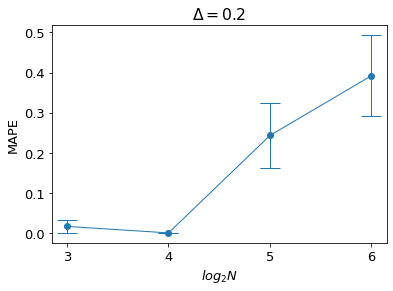

In [ ]:
log2N_list = [3, 4, 5, 6]
plt.rcParams["font.size"] = 13  # フォントの大きさ
plt.errorbar(
    log2N_list,
    mean_MAPE_D02,
    yerr=stder_MAPE_D02,
    marker="o",
    capthick=1,
    capsize=10,
    lw=1,
)
plt.gca().xaxis.set_major_locator(
    ticker.MaxNLocator(integer=True)
)  # 横軸を整数値で表示
plt.ylabel("MAPE")
plt.xlabel("$log_{2}N$")
plt.title("$\Delta=0.2$")
plt.show()

### $\Delta=0.6$ の場合

$\Delta=0.2$ のときと同様に、問題サイズ $ N=8,16,32,64 $ の QKP をランダムに 10 個ずつ生成していきます。

In [ ]:
Delta06 = 0.6

f_inst_D06 = []
G_inst_D06 = []
D_inst_D06 = []

for N in N_list:
    for i in range(N_inst):
        f, G, D = make_QKP(N, M, Delta06)
        f_inst_D06.append(f)
        G_inst_D06.append(G)
        D_inst_D06.append(D)

#### ADMM アルゴリズムの実行

生成したそれぞれの QKP に対して ADMM アルゴリズムを実行し、解を求めていきます。

In [ ]:
x_feas_inst_D06 = []
E_ineq_inst_D06 = []

for i in trange(N_inst * len_N_list):
    x_feas, E_ineq = qa_admm(
        f_inst_D06[i],
        G_inst_D06[i],
        D_inst_D06[i],
        rho,
        M,
        N_nu,
        N_list[i // N_inst],
        t_max,
        t_conv,
        epsilon,
        gamma,
    )
    x_feas_inst_D06.append(x_feas)
    E_ineq_inst_D06.append(E_ineq)

100%|██████████| 40/40 [15:08<00:00, 22.71s/it]


#### Gurobi から厳密解を取得

続いてそれぞれの QKP に対して Gurobi を実行し、厳密解を求めていきます。

In [ ]:
x_opt_inst_D06 = []
E_opt_inst_D06 = []

for k in trange(N_inst * len_N_list):
    x_exact, val_opt = grb_exact_qkp(f_inst_D06[k], G_inst_D06[k][0], D_inst_D06[k][0])
    x_opt_inst_D06.append(x_exact)
    E_opt_inst_D06.append(val_opt)

100%|██████████| 40/40 [00:07<00:00,  5.66it/s] 


#### 結果の比較

式 (9) に基づき、問題サイズごとに MAPE のインスタンス平均および標準偏差を求めます。

In [ ]:
mean_MAPE_D06 = np.zeros(len_N_list)
stder_MAPE_D06 = np.zeros(len_N_list)

for i in range(len_N_list):
    # 最適値の符号を反転させることで、元の最大化問題の最適値に戻す
    mean_MAPE_D06[i] = mean(
        [
            abs(E_ineq_inst_D06[N_inst * i + j][-1] - E_opt_inst_D06[N_inst * i + j])
            / -E_opt_inst_D06[N_inst * i + j]
            for j in range(N_inst)
            if E_ineq_inst_D06[N_inst * i + j][-1] is not None
        ]
    )
    stder_MAPE_D06[i] = stdev(
        [
            abs(E_ineq_inst_D06[N_inst * i + j][-1] - E_opt_inst_D06[N_inst * i + j])
            / -E_opt_inst_D06[N_inst * i + j]
            for j in range(N_inst)
            if E_ineq_inst_D06[N_inst * i + j][-1] is not None
        ]
    ) / np.sqrt(N_inst)

実験結果として、MAPE の問題サイズ $N$ 依存性を示すグラフを表示します。

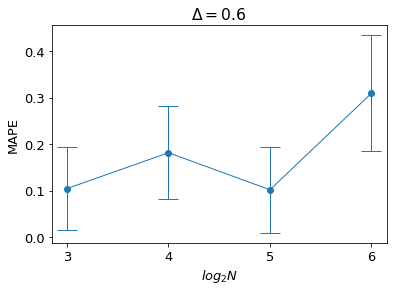

In [ ]:
plt.errorbar(
    log2N_list,
    mean_MAPE_D06,
    yerr=stder_MAPE_D06,
    marker="o",
    capthick=1,
    capsize=10,
    lw=1,
)
plt.gca().xaxis.set_major_locator(
    ticker.MaxNLocator(integer=True)
)  # 横軸を整数値で表示
plt.ylabel("MAPE")
plt.xlabel("$log_{2}N$")
plt.title("$\Delta=0.6$")
plt.show()

### $\Delta=1.0$ の場合

問題サイズ $ N=8,16,32,64 $ の QKP をランダムに 10 個ずつ生成していきます。

In [ ]:
Delta10 = 1.0

f_inst_D10 = []
G_inst_D10 = []
D_inst_D10 = []

for N in N_list:
    for i in range(N_inst):
        f, G, D = make_QKP(N, M, Delta10)
        f_inst_D10.append(f)
        G_inst_D10.append(G)
        D_inst_D10.append(D)

#### ADMM アルゴリズムの実行

生成したそれぞれの QKP に対して ADMM アルゴリズムを実行し、解を求めていきます。

In [ ]:
x_feas_inst_D10 = []
E_ineq_inst_D10 = []

for i in trange(N_inst * len_N_list):
    x_feas, E_ineq = qa_admm(
        f_inst_D10[i],
        G_inst_D10[i],
        D_inst_D10[i],
        rho,
        M,
        N_nu,
        N_list[i // N_inst],
        t_max,
        t_conv,
        epsilon,
        gamma,
    )
    x_feas_inst_D10.append(x_feas)
    E_ineq_inst_D10.append(E_ineq)

100%|██████████| 40/40 [17:31<00:00, 26.29s/it]


#### Gurobi から厳密解を取得

続いてそれぞれの QKP に対して Gurobi を実行し、厳密解を求めていきます。この処理には数時間かかります。

In [ ]:
x_opt_inst_D10 = []
E_opt_inst_D10 = []

for k in trange(N_inst * len_N_list):
    x_exact, val_opt = grb_exact_qkp(f_inst_D10[k], G_inst_D10[k][0], D_inst_D10[k][0])
    x_opt_inst_D10.append(x_exact)
    E_opt_inst_D10.append(val_opt)

100%|██████████| 40/40 [6:32:52<00:00, 589.31s/it]   


#### 結果の比較

式 (9) に基づき、問題サイズごとにMAPE のインスタンス平均および標準偏差を求めます。

In [ ]:
mean_MAPE_D10 = np.zeros(len_N_list)
stder_MAPE_D10 = np.zeros(len_N_list)

for i in range(len_N_list):
    # 最適値の符号を反転させることで、元の最大化問題の最適値に戻す
    mean_MAPE_D10[i] = mean(
        [
            abs(E_ineq_inst_D10[N_inst * i + j][-1] - E_opt_inst_D10[N_inst * i + j])
            / -E_opt_inst_D10[N_inst * i + j]
            for j in range(N_inst)
            if E_ineq_inst_D10[N_inst * i + j][-1] is not None
        ]
    )
    stder_MAPE_D10[i] = stdev(
        [
            abs(E_ineq_inst_D10[N_inst * i + j][-1] - E_opt_inst_D10[N_inst * i + j])
            / -E_opt_inst_D10[N_inst * i + j]
            for j in range(N_inst)
            if E_ineq_inst_D10[N_inst * i + j][-1] is not None
        ]
    ) / np.sqrt(N_inst)

実験結果として、MAPE の問題サイズ $N$ 依存性を示すグラフを表示します。

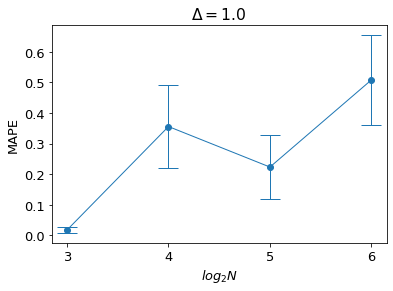

In [ ]:
plt.errorbar(
    log2N_list,
    mean_MAPE_D10,
    yerr=stder_MAPE_D10,
    marker="o",
    capthick=1,
    capsize=10,
    lw=1,
)
plt.gca().xaxis.set_major_locator(
    ticker.MaxNLocator(integer=True)
)  # 横軸を整数値で表示
plt.ylabel("MAPE")
plt.xlabel("$log_{2}N$")
plt.title("$\Delta=1.0$")
plt.show()

## 実験結果のまとめ

$\Delta = 0.2, 0.6, 1.0$ の場合それぞれについて、MAPE の問題サイズ依存性を求めてきました。最後に、各 $\Delta$ における結果を同じグラフにプロットして比較してみます。

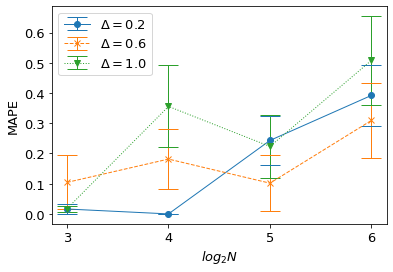

In [ ]:
plt.errorbar(
    log2N_list,
    mean_MAPE_D02,
    yerr=stder_MAPE_D02,
    linestyle="solid",
    marker="o",
    capthick=1,
    capsize=10,
    lw=1,
    label="$\Delta=0.2$",
)
plt.errorbar(
    log2N_list,
    mean_MAPE_D06,
    yerr=stder_MAPE_D06,
    linestyle="dashed",
    marker="x",
    capthick=1,
    capsize=10,
    lw=1,
    label="$\Delta=0.6$",
)
plt.errorbar(
    log2N_list,
    mean_MAPE_D10,
    yerr=stder_MAPE_D10,
    linestyle="dotted",
    marker="v",
    capthick=1,
    capsize=10,
    lw=1,
    label="$\Delta=1.0$",
)
plt.gca().xaxis.set_major_locator(
    ticker.MaxNLocator(integer=True)
)  # 横軸を整数値で表示
plt.xlabel("$log_{2}N$")
plt.ylabel("MAPE")
plt.legend()

$\Delta$ がいずれの場合においても、問題サイズ $N$ が増加するごとに MAPE は増加する傾向にあることが分かります。しかし、$\Delta$ による MAPE の違いはあまり見られません。また、エラーバーも大きく、インスタンスごとに MAPE が大きく異なる結果となりました。

元論文では $\Delta$ が大きいほど MAPE が小さくなるという結果が示されており、$\Delta=1.0$ の MAPE はほぼゼロとなっていました。したがって、今回得られた結果はそれとは大きく異なります。原因の 1 つとして、元論文では D-Wave 2000Q を使用していましたが、D-Wave 2000Q は既にサービスが終了してしまっているため、今回の実験では D-Wave Advantage6.3 を使用したことが挙げられます。そうは言っても、結果にこれほど大きな違いが出た原因は不明です。

# まとめ

本記事では、元論文の ADMM アルゴリズムを実装しました。そして、再現実験として $\Delta = 0.2, 0.6, 1.0$ について MAPE の $N$ 依存性を評価しました。

元論文とは異なり、インスタンスによって MAPE が大きく変化する結果となりました。また、$\Delta$ による違いもはっきりとは見られませんでした。

# あとがき

元論文の結果が再現されたとは言い難い結果とはなりましたが、拡張ラグランジュ法や ADMM の勉強にもなり、良い経験になりました。また、今回は QKP という不等式制約が 1 つだけの問題を扱いましたが、より多くの不等式制約が含まれる問題も今回の手法で扱えるかどうかを確かめてみたいと思いました。